In [61]:
import sys
import json
import random
import math
import numpy as np
from matplotlib import pyplot as plt

## Load and parse data

In [62]:
samples_files = ["2021-11-09-standup-sitdown-stationary-waving-clapping-nodding-walking.samples"]
#samples_files = ["/content/drive/MyDrive/data/" + f for f in samples_files]
all_samples_by_file = []

for samples_file in samples_files:
    all_samples = []
    with open(samples_file, "r") as file:
        for line in file.readlines():
            sample = json.loads(line)
            all_samples.append(sample)
    
    all_samples_by_file.append(all_samples)

stations = {next(iter(sample[0].keys())) for sample in all_samples_by_file[0]}

In [63]:
samples_by_station = {}
for station in stations:
    samples_by_station[station] = []
    for f in all_samples_by_file:
        samples_in_file_for_this_station = []
        for sample in f:
            if sample[0][station]:
                # assume there is a sample of this station in all frames
                frames = []
                for frame in sample:
                    frames.append(frame[station])
                samples_in_file_for_this_station.append(frames)
                
        samples_by_station[station].append(samples_in_file_for_this_station)

In [64]:
selected_station = next(iter(stations))
# selected_station = "..."

samples = samples_by_station[selected_station] # list of datasets

## Prepare data

#### Configuration

In [65]:
subcarriers = len(samples[0][0][0]["angles"])

val_pct = 0.2
test_pct = 0.2
class_count = max([int(sample[0]["cl"]) for sample in samples[0]])
frame_count = len(samples[0][0])

use_dists = True
data_layers = 2 if use_dists else 1

if samples[0][0][0]["angles3"] is not None:
    use_multiple_antennas = True
    print("Using 3 TX antennas")
    data_layers *= 3

tx_antennas = (3 if use_multiple_antennas else 1)

print(f"Subcarriers {subcarriers}")

print(f"Sample size: {frame_count}x{subcarriers}x{data_layers}")
print(f"Classes: {class_count}")
print(f"Frames: {frame_count}")

Using 3 TX antennas
Subcarriers 55
Sample size: 20x55x6
Classes: 7
Frames: 20


In [69]:
flat_fun_avg = lambda l: sum(l) / len(l)
flat_fun_max = lambda l: max(l)
flat_fun_sum = lambda l: sum(l)

angle_change_subcarrier_flat_fun = flat_fun_avg
angle_change_antenna_flat_fun = flat_fun_max
dist_change_subcarrier_flat_fun = flat_fun_avg
dist_change_antenna_flat_fun = flat_fun_max

In [70]:
def obtain_single_antenna_angle_change(current, previous):
    changes = [current[i] % (math.pi * 2.0) for i in range(subcarriers)] # TODO: WRAP AROUND
    return angle_change_subcarrier_flat_fun(current)
        

def obtain_angle_change(current, previous):
    field = lambda i: "angles" if i == 0 else f"angles{i+1}"
    antenna_changes = [obtain_single_antenna_angle_change(current[field(i)], previous[field(i)]) for i in range(tx_antennas)]
    
    return angle_change_antenna_flat_fun(antenna_changes)

def obtain_single_antenna_dist_change(current, previous):
    changes = [current[i] for i in range(subcarriers)]
    return dist_change_subcarrier_flat_fun(current)
        

def obtain_dist_change(current, previous):
    field = lambda i: "dists" if i == 0 else f"dists{i+1}"
    antenna_changes = [obtain_single_antenna_dist_change(current[field(i)], previous[field(i)]) for i in range(tx_antennas)]
    
    return dist_change_antenna_flat_fun(antenna_changes)
    

def obtain_change_pattern(sample):
    pattern = []
    for i in range(1, len(sample)):
        current_frame = sample[i]
        previous_frame = sample[i-1]
        
        angle_change = obtain_angle_change(current_frame, previous_frame)
        dist_change = obtain_dist_change(current_frame, previous_frame) # TODO what to use?
        
        pattern.append(angle_change)
    
    return pattern

### Visualization

In [ ]:
classes = ["standup", "sitdown", "stationary", "waving", "clapping", "nodding", "walking"]

dataset1 = samples[0]

for sample in dataset1:
    clazz = sample[0]["cl"]
    
    fig = plt.figure()
    plt.title("Class: " + str(clazz) + " (" + classes[clazz-1] + ")")
    #plt.ylim(1,5)
    
    pattern = obtain_change_pattern(sample)
    plt.plot(pattern)

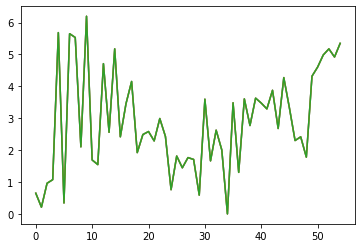

In [85]:
sample = dataset1[0]

fig = plt.figure()
# c = obtain_single_antenna_angle_change(sample[0]["angles"])

plt.plot(sample[0]["angles"])
plt.plot(sample[0]["angles2"])
plt.plot(sample[0]["angles3"])

## Learning

## Prediction
Use convolution

In [29]:
#import matplotlib.pyplot as plt

#s = []

#sample = samples[0][3][0]
#for subcarrier in range(subcarriers):
#    s.append(sample["angles"][subcarrier])

#plt.plot(s)